## Imports

In [36]:
from pathlib import Path
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import tqdm

from ephys_atlas.plots import figure_features_chspace, plot_probe_rect, plot_probe_rect2
from ephys_atlas.encoding import voltage_features_set
from ephys_atlas.data import load_voltage_features, prepare_df_voltage

In [4]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'DejaVu Sans',
    #'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    #'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})

## Constants

In [5]:
QUANTILES = [0.01, 0.1, 0.9, 0.99]
BINS = 50

## Data loading

In [6]:
local_data_path = Path('/home/cyrille/GIT/IBL/paper-ephys-atlas/data')

features = voltage_features_set()
mapping = 'Allen'
label = 'latest'

In [7]:
df_voltage, df_clusters, df_channels, df_probes = \
    load_voltage_features(local_data_path.joinpath(label), mapping=mapping)

2025-02-19 15:43:38 INFO     data.py:399  Loaded 391314 channels
2025-02-19 15:43:38 INFO     data.py:401  Remains 384418 channels after NaNs filtering


In [8]:
df_voltage = prepare_df_voltage(df_voltage, df_channels)

## Regions

In [9]:
from iblatlas.atlas import BrainRegions
br = BrainRegions()

In [10]:
beryl_ids = df_voltage.beryl_id.unique()
acronyms = br.id2acronym(beryl_ids)
idx = np.argsort(acronyms)
acronyms = acronyms[idx]
beryl_ids = beryl_ids[idx]

## Features

In [11]:
pids = df_voltage.index.get_level_values(0).unique()

In [12]:
df_voltage

alpha_mean   alpha_std  \
pid                                  channel                           
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0        197.210450  190.478658   
                                     1        194.839222  186.516420   
                                     2        138.978804  195.718681   
                                     3        169.178477  110.850311   
                                     4        122.773706   80.443544   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      115.299620   74.028424   
                                     380      142.860548   94.239179   
                                     381      147.808486  133.909545   
                                     382      196.486313  194.143250   
                                     383      171.983269  147.854649   

                                              spike_count  peak_time_secs  \
pid                                  channel                                
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0                786        0.000025   
                                     1               1219        0.000024   
                                     2               1413        0.000027   
                                     3                399        0.000026   
                                     4                612        0.000022   
...                                                   ...             ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379              361        0.000006   
                                     380              513        0.000006   
                                     381             1029        0.000004   
                                     382              578        0.000005   
                                     383              501        0.000010   

                                              peak_val  trough_time_secs  \
pid                                  channel                               
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0       -3.364660          0.000339   
                                     1       -3.251131          0.000342   
                                     2       -3.822328          0.000341   
                                     3       -2.894536          0.000360   
                                     4       -2.923776          0.000340   
...                                                ...               ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -0.758633          0.000362   
                                     380     -1.222476          0.000360   
                                     381     -0.817315          0.000359   
                                     382     -1.281809          0.000351   
                                     383     -1.107193          0.000354   

                                              trough_val  tip_time_secs  \
pid                                  channel                              
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0          1.418666      -0.000378   
                                     1          1.362056      -0.000367   
                                     2          1.580183      -0.000375   
                                     3          1.176652      -0.000378   
                                     4          1.230062      -0.000365   
...                                                  ...            ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379        0.270088      -0.000432   
                                     380        0.445692      -0.000432   
                                     381        0.279528      -0.000433   
                                     382        0.445679      -0.000405   
                                     383        0.445684      -0.000433   

                                               tip_val  recovery_time_secs  \
pid                                  channel                    

In [13]:
df_voltage.shape

(326802, 62)

In [14]:
df_voltage.acronym

pid                                   channel
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4  0          TRN
                                      1          TRN
                                      2          TRN
                                      3          TRN
                                      4          TRN
                                                ... 
ffb1b072-2de7-44a4-8115-5799b9866382  379        PRM
                                      380        PRM
                                      381        PRM
                                      382        PRM
                                      383        PRM
Name: acronym, Length: 326802, dtype: object

In [15]:
df_voltage.index.names

FrozenList(['pid', 'channel'])

In [16]:
df_voltage.index.shape

(326802,)

## Distribution plotting functions

In [141]:
def select_series(df, feature=None, acronym=None, beryl_id=None):
    if acronym is not None:
        series = df.loc[df['acronym'] == acronym, feature or features]
    elif beryl_id is not None:
        series = df.loc[df['beryl_id'] == beryl_id, feature or features]
    elif feature is not None:
        series = df[feature]
    return series

In [18]:
def plot_histogram(series, ax=None, quantiles=None, bins=None, xlabel=None, title=None):
    quantiles = quantiles if quantiles is not None else QUANTILES
    quantile_values = np.quantile(series, quantiles)

    bins = bins if bins is not None else BINS

    hist_values, bin_edges = np.histogram(series, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    color_indices = np.digitize(bin_centers, quantile_values, right=True)
    colors = cm.viridis(color_indices / color_indices.max())

    ax.bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), color=colors, align='edge')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.text(
        0.95, 0.95, f"{len(series):,} samples", 
        transform=ax.transAxes, ha='right', va='top', fontsize=12,
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', direction='out', length=6)
    ax.set_facecolor('#f9f9f9')
    plt.tight_layout()

## Plots

## Channels

In [20]:
df_channels.columns

Index(['x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'histology', 'version', 'x_target', 'y_target', 'z_target',
       'atlas_id_target'],
      dtype='object')

In [21]:
df_channels.index.names

FrozenList(['pid', 'channel'])

In [22]:
df_channels.index.shape

(392044,)

In [23]:
df_channels.acronym

pid                                   channel
ee3345e6-540d-4cea-9e4a-7f1b2fb9a4e4  0              MRN
                                      1              MRN
                                      2              MRN
                                      3              MRN
                                      4              MRN
                                                  ...   
b78b3c42-eee5-47c6-9717-743b78c0b721  379        VISp2/3
                                      380        VISp2/3
                                      381        VISp2/3
                                      382        VISp2/3
                                      383        VISp2/3
Name: acronym, Length: 392044, dtype: object

## Distribution comparison

In [24]:
feature = features[0]

In [25]:
series = select_series(df_voltage, feature)
series


pid                                   channel
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4  0         -95.672768
                                      1         -95.404884
                                      2         -94.714439
                                      3         -95.400200
                                      4         -95.505722
                                                   ...    
ffb1b072-2de7-44a4-8115-5799b9866382  379       -90.801094
                                      380       -90.039459
                                      381       -89.964828
                                      382       -89.319679
                                      383       -89.231880
Name: rms_ap, Length: 326802, dtype: float32

In [26]:
_, idx = br.id2index(beryl_ids, mapping="Beryl")
idx = np.array([_[0] for _ in idx])

In [27]:
colors = br.rgb[idx] / 255.0

In [28]:
df_voltage.loc[series.index]

alpha_mean   alpha_std  \
pid                                  channel                           
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0        197.210450  190.478658   
                                     1        194.839222  186.516420   
                                     2        138.978804  195.718681   
                                     3        169.178477  110.850311   
                                     4        122.773706   80.443544   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      115.299620   74.028424   
                                     380      142.860548   94.239179   
                                     381      147.808486  133.909545   
                                     382      196.486313  194.143250   
                                     383      171.983269  147.854649   

                                              spike_count  peak_time_secs  \
pid                                  channel                                
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0                786        0.000025   
                                     1               1219        0.000024   
                                     2               1413        0.000027   
                                     3                399        0.000026   
                                     4                612        0.000022   
...                                                   ...             ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379              361        0.000006   
                                     380              513        0.000006   
                                     381             1029        0.000004   
                                     382              578        0.000005   
                                     383              501        0.000010   

                                              peak_val  trough_time_secs  \
pid                                  channel                               
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0       -3.364660          0.000339   
                                     1       -3.251131          0.000342   
                                     2       -3.822328          0.000341   
                                     3       -2.894536          0.000360   
                                     4       -2.923776          0.000340   
...                                                ...               ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -0.758633          0.000362   
                                     380     -1.222476          0.000360   
                                     381     -0.817315          0.000359   
                                     382     -1.281809          0.000351   
                                     383     -1.107193          0.000354   

                                              trough_val  tip_time_secs  \
pid                                  channel                              
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0          1.418666      -0.000378   
                                     1          1.362056      -0.000367   
                                     2          1.580183      -0.000375   
                                     3          1.176652      -0.000378   
                                     4          1.230062      -0.000365   
...                                                  ...            ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379        0.270088      -0.000432   
                                     380        0.445692      -0.000432   
                                     381        0.279528      -0.000433   
                                     382        0.445679      -0.000405   
                                     383        0.445684      -0.000433   

                                               tip_val  recovery_time_secs  \
pid                                  channel                    

In [29]:
agg_funcs = {
    "median": "median",
    "std": "std",
    "min": "min",
    "max": "max",
    "q01": lambda x: x.quantile(0.01),
    "q99": lambda x: x.quantile(0.99),
}

In [30]:
df_stats_bak = {}
for agg_name, agg_func in agg_funcs.items():
    df_stat_baks[agg_name] = df_voltage.groupby("beryl_id")[features].agg(agg_func)

In [34]:
acronyms = br.id2acronym(beryl_ids, mapping='Beryl')

## Outlier detection

In [129]:
import numpy as np
from sklearn.neighbors import KernelDensity

def detect_outliers_kde(train_data: np.ndarray, test_data: np.ndarray):
    """
    Detects outliers in D-dimensional space using Kernel Density Estimation (KDE).

    Parameters:
    - train_data: (N, D) numpy array, training dataset (assumed to represent the true distribution).
    - test_data: (M, D) numpy array, test dataset (points to evaluate for outlier probability).

    Returns:
    - outlier_probs: (M,) numpy array, probability of each test sample being an outlier.
    """
    kde = KernelDensity()
    kde.fit(train_data)
    mean_score = kde.score(train_data) / train_data.shape[0]
    out = 1 - np.exp(1-kde.score_samples(test_data) / mean_score)
    return out

In [158]:
outliers = []
for beryl_id in tqdm.tqdm(beryl_ids):
    series = select_series(df_voltage, beryl_id=beryl_id)
    train_data = series.values
    test_data = train_data
    scores = detect_outliers_kde(train_data, test_data)
    outliers.append(scores)
outliers = sorted(outliers, key=len)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:53<00:00,  5.35it/s]


In [159]:
n = len(outliers[-1])

In [160]:
outliers_arr = np.zeros((len(beryl_ids), n), dtype=np.float32)
for outlier in outliers:
    outliers_arr[i, :len(outlier)] = outlier

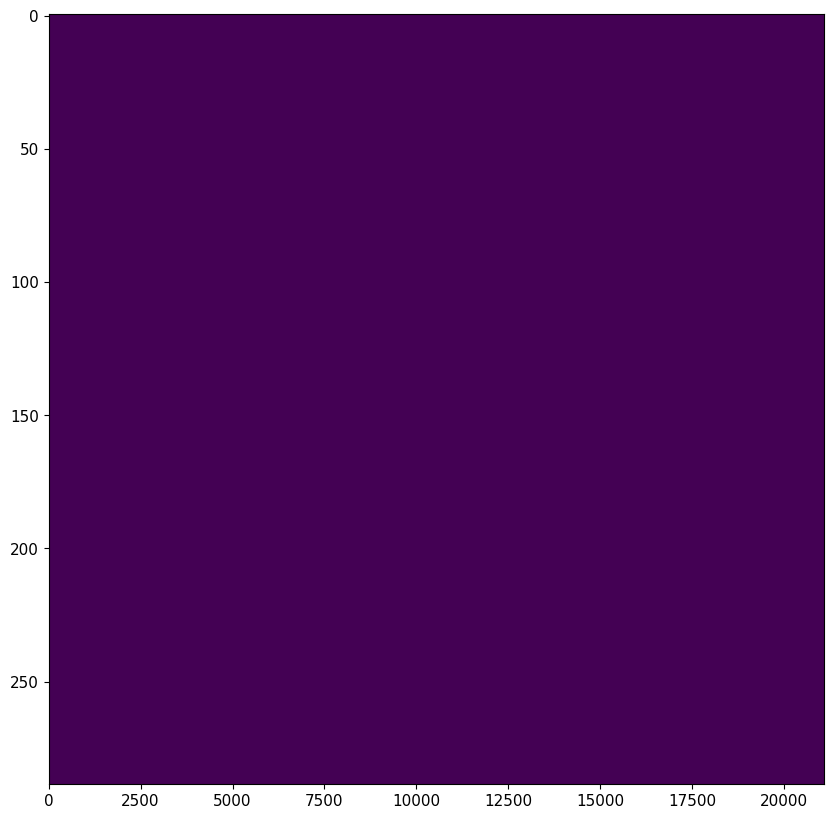

In [165]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(outliers_arr[:, :], vmin=0, vmax=1, interpolation='none', aspect='auto')